In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [8]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import json

from PIL import Image
from IPython.display import display

import tensorflow as tf
from tensorflow.keras import layers, models

from build_model_ed import build_model_1, build_model_2, build_model_3
from build_model_lstm import build_model_lstm_1, build_model_lstm_2, build_model_lstm_3
from get_frames import get_frames
from get_encoder_decoder import get_encoder_decoder
from get_errors import get_ssim, get_mse, get_errors
from assemble_image import assemble_image
from load_models import load_encoder_decoder_model, load_lstm_model
from prediction import predict_step, predict_image, plot_prediction

In [9]:
#gpu check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
#load data image list
test_size = 0.1
stride_step = 50
norm_factor=1
dtype = 'uint8'

filename = f'save_data/e_d_test_all_str_{stride_step}_ts_{test_size}_{dtype}_norm_{norm_factor}.pkl'
#load data
with open(filename, 'rb') as f:
    image_list,frames_data = pickle.load(f)
    
#get input shape for encoder-decoder model
input_shape_e_d = frames_data.shape[1:]
del frames_data

In [11]:
#load models
unit_numb = 5
stride_step = 50

#lstm
cells_list = [10,10]
window_size = 6
window_size_predicted = 6
overlap = 3

#load encoder-decoder
model_ed_name = f'model_ed_2_ps_2_bn_True_du_{unit_numb}'
model_ed_path = f'saved_models/stride_{stride_step}/ed'
model_encoder, model_decoder = load_encoder_decoder_model(model_ed_name, model_ed_path)

#load lstm model
input_shape = (None, unit_numb)
cells_list_str = '_'.join(str(x) for x in cells_list)
model_lstm_name = f'model_lstm_window_{window_size_predicted}_overlap_{overlap}_units_{unit_numb}_bs2_{input_shape[-1]}_{cells_list_str}_ifDense_{True}'
#new format
#model_lstm_name = f'model_lstm_win_{window_size_window_size_predicted}_ovrp_{overlap}_un_{unit_numb}_c_{cells_list_str}'
model_lstm_path = f'saved_models/stride_{stride_step}/lstm'
model_lstm = load_lstm_model(model_lstm_name, model_lstm_path)

if 1:
    print(f'Encoder input shape: {model_encoder.layers[0].input_shape}')
    print(f'Encoder output shape: {model_encoder.layers[-1].output_shape}')
    print(f'Decoder input shape: {model_decoder.layers[0].input_shape}')
    print(f'Decoder output shape: {model_decoder.layers[-1].output_shape}')
    print(f'LSTM input shape: {model_lstm.layers[0].input_shape}')
    print(f'LSTM output shape: {model_lstm.layers[-1].output_shape}')

Encoder input shape: (None, 2048, 50, 3)
Encoder output shape: (None, 5)
Decoder input shape: (None, 5)
Decoder output shape: (None, 2048, 50, 3)
LSTM input shape: [(None, None, 5)]
LSTM output shape: (None, None, 5)


In [ ]:
#rewrite lstm settings to json
unit_numb = 5
stride_step = 50

cells_list = [10, 10]
many_to_many = True
overlap = 3
window_size = 6
window_size_predicted = 6
ifDense = True


input_shape = (None, unit_numb)
cells_list_str = '_'.join(str(x) for x in cells_list)
model_lstm_name = f'model_lstm_window_{window_size_predicted}_overlap_{overlap}_units_{unit_numb}_bs2_{input_shape[-1]}_{cells_list_str}_ifDense_{True}'
model_lstm_path = f'saved_models/stride_{stride_step}/lstm'

lstm_settings = {
    'unit_numb':unit_numb,
    'window_size_predicted':window_size_predicted,
    'window_size':window_size,
    'overlap':overlap,
    'cells_list':cells_list,
    'many_to_many':many_to_many,
    'ifDense':ifDense,
}

with open(f'{model_lstm_path}/{model_lstm_name}_settings.json', 'w') as f:
    json.dump(lstm_settings, f)

In [12]:
#image list
print('Image list:')
print('\n'.join([f'{i}: {image}' for i, image in enumerate(image_list)]))

Image list:
0: Fold21.png
1: Pucker3.png
2: Fold3.png
3: Pucker23.png
4: Pucker16.png
5: Twist31.png
6: Pucker7.png
7: Pucker26.png
8: Pucker24.png


In [13]:
#choose image
test_case = image_list[5]


#get frames from the image
path_list = ['PuckerImages//RGB_cropped',
             'TwistImages//RGB',
             'FoldImages//RGB',]

print(f'Chosen image: {test_case}')
for path in path_list:
    if test_case[:4]==path[:4]:
        break        
img = Image.open(f'{path}//{test_case}')
image_data_gt = np.array(img, dtype=dtype)
#crop the end
image_data_gt = image_data_gt[:,:-96,:]
print(f'Image shape: {image_data_gt.shape}')
#get frames
image_data_frames_gt = get_frames(image_data_gt, stride_step, ifPrint = False)
print(f'Framed image shape: {image_data_frames_gt.shape}')

Chosen image: Twist31.png
Image shape: (2048, 4000, 3)
Framed image shape: (80, 2048, 50, 3)


In [14]:
#predict
frames_to_pred_total = 5
repeat_prediction = 1
verbose = 0

image_data_frames_list = predict_image(
    image_data_frames_gt, 
    window_size, 
    window_size_predicted, 
    overlap, 
    repeat_prediction, 
    model_encoder,
    model_decoder, 
    model_lstm, 
    verbose=verbose,
    frames_to_pred_total=frames_to_pred_total
)

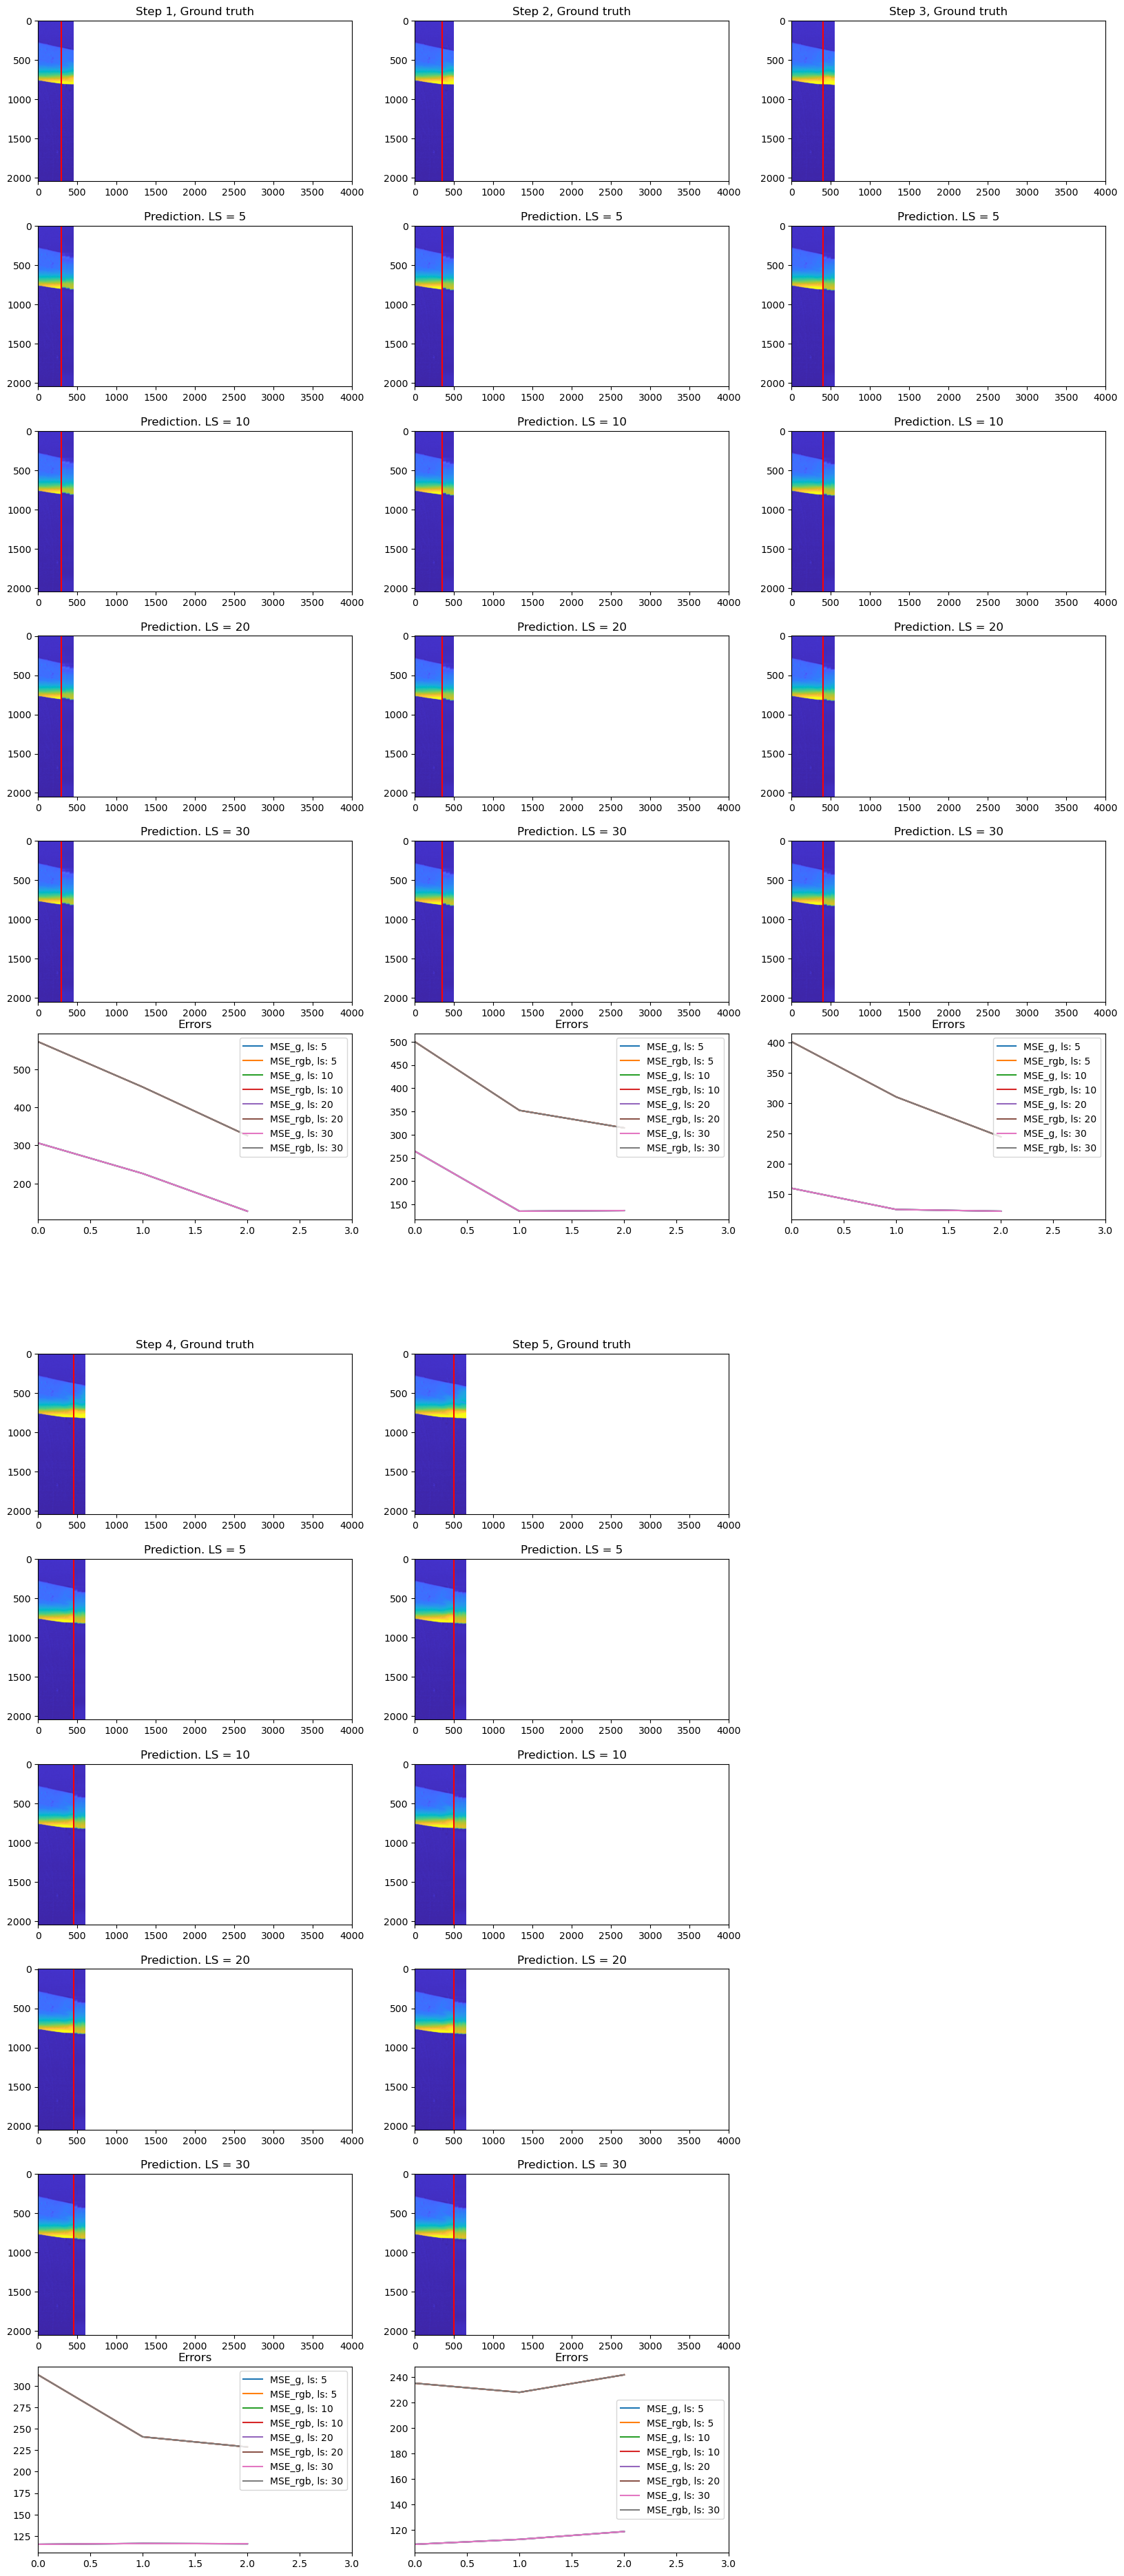

In [31]:
unit_numb_list = [5,10,20,30]
predicted_data = [image_data_frames_list, image_data_frames_list,image_data_frames_list,image_data_frames_list]

plot_prediction(
    image_data_frames_gt,
    predicted_data,
    unit_numb_list,
    window_size,
    window_size_predicted,
    overlap,
    repeat_prediction,
    numb_cols=3
)

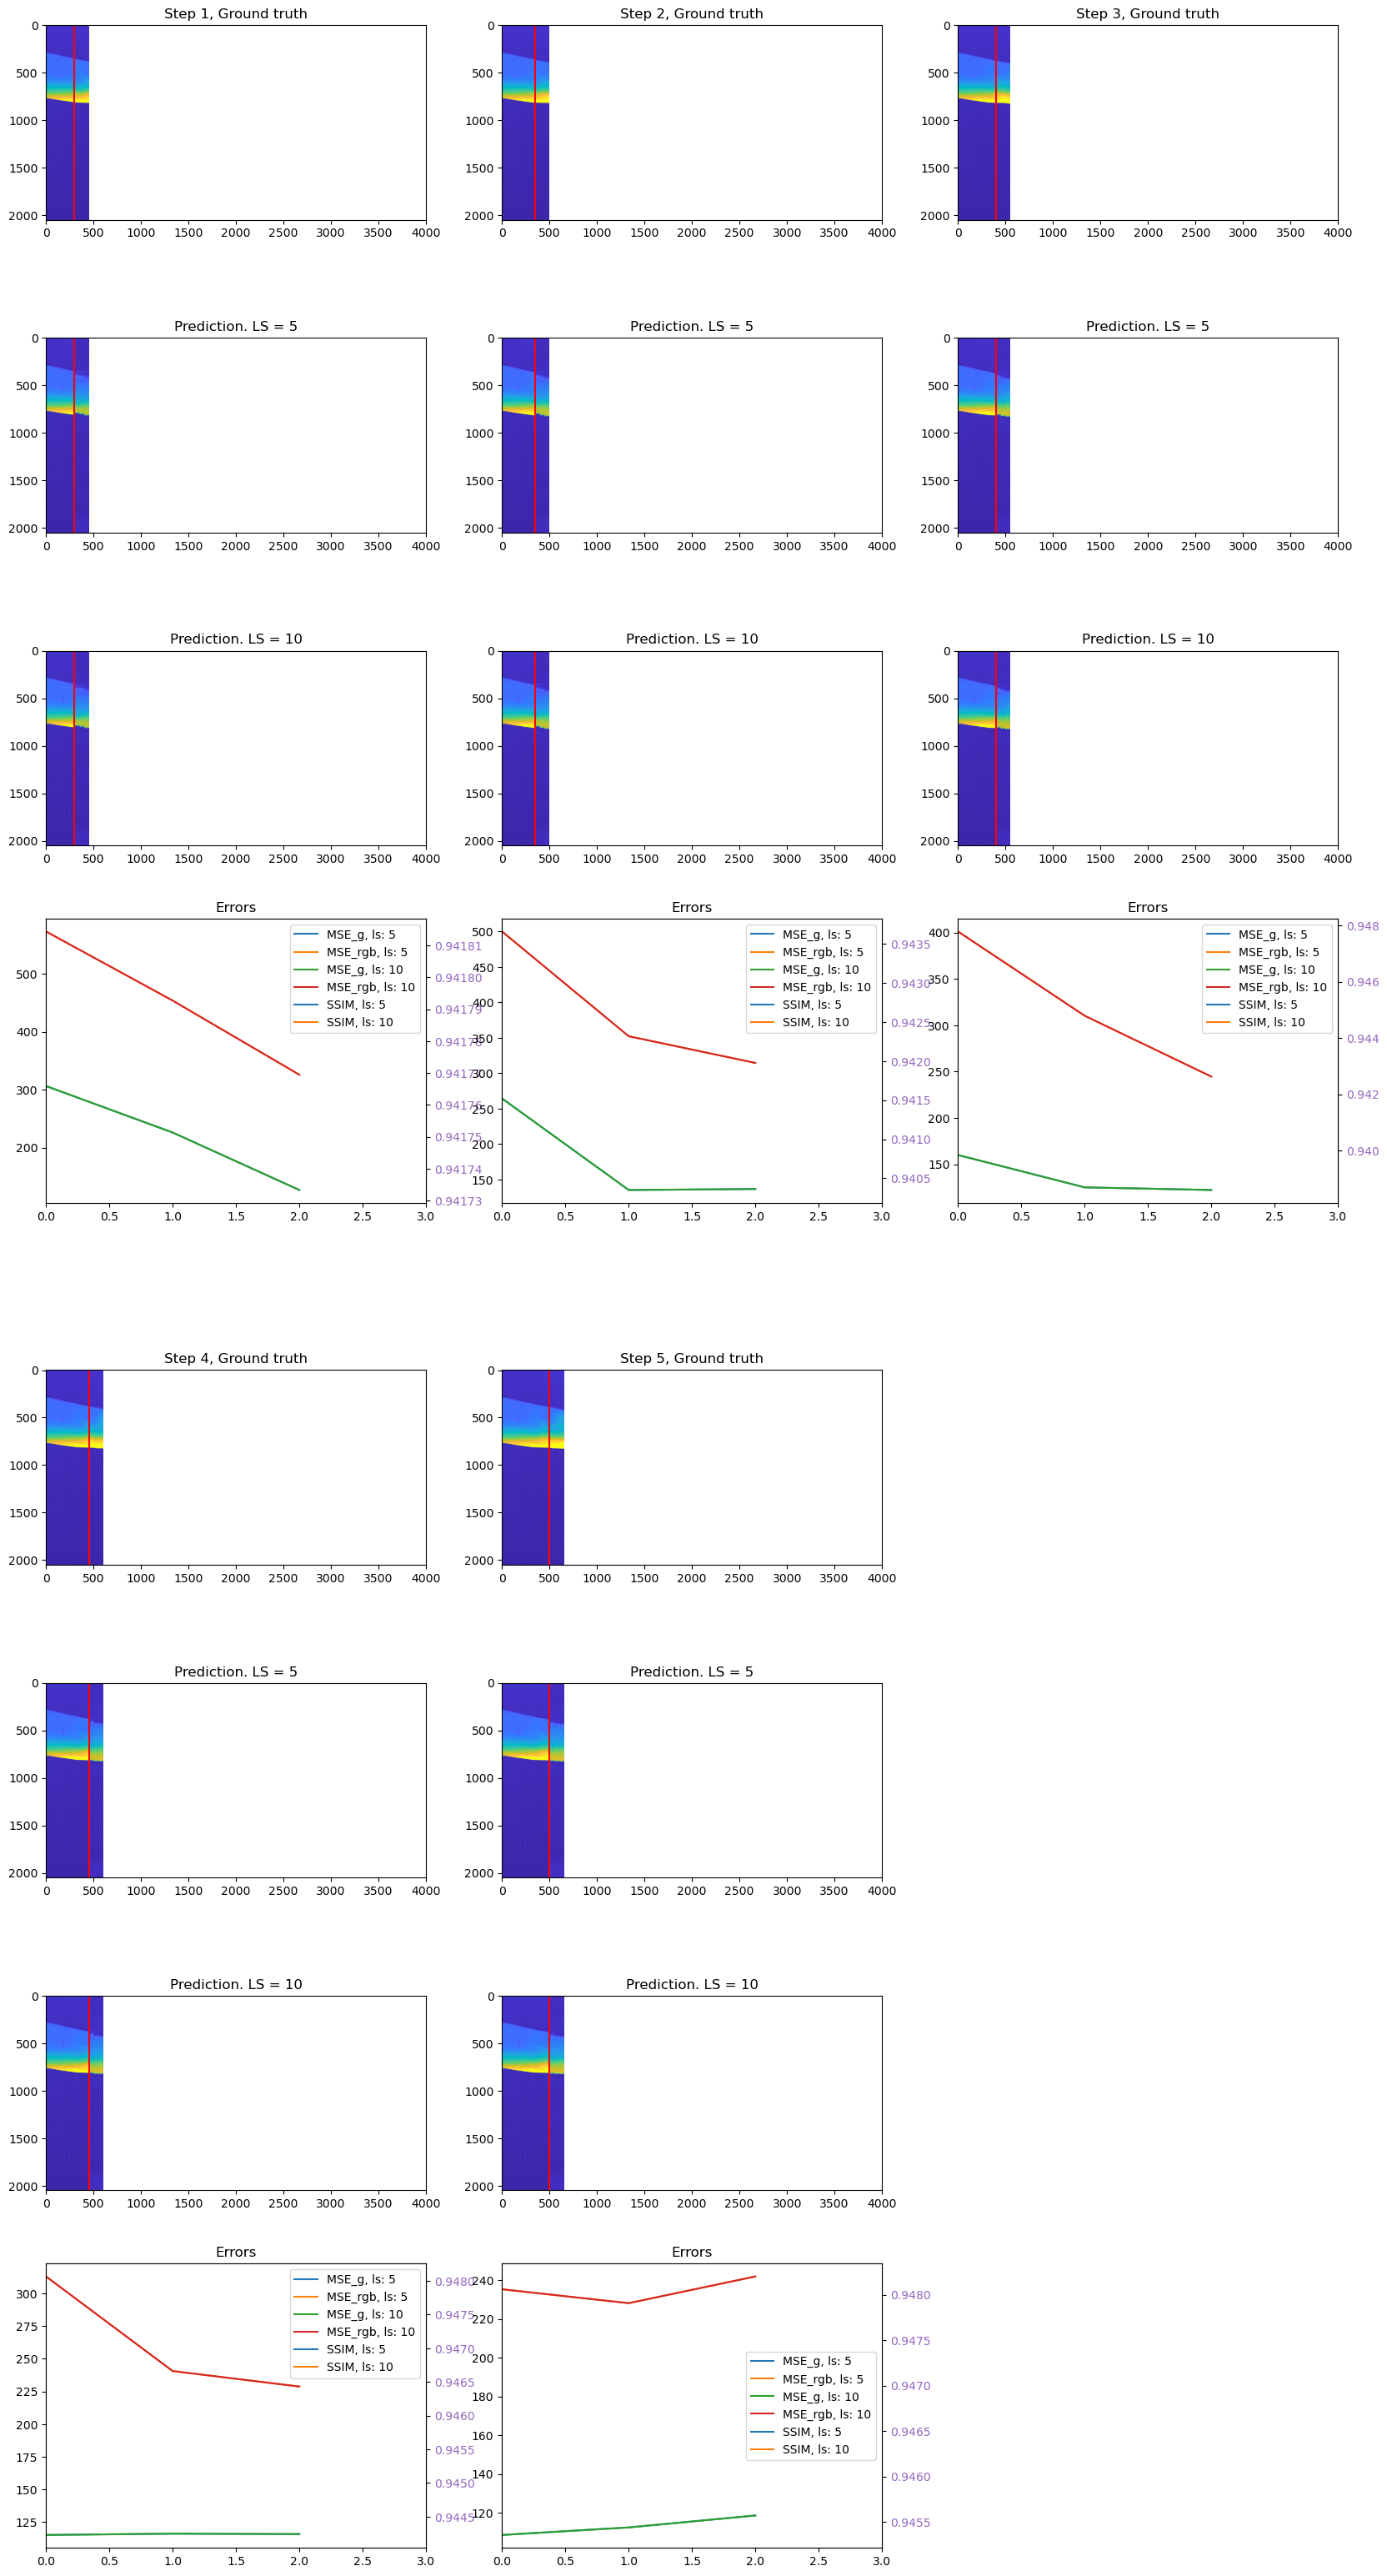

In [54]:

image_data_frames_list1 = image_data_frames_list
image_data_frames_list2 = image_data_frames_list

predicted_data = [image_data_frames_list1, image_data_frames_list2]

frames_to_pred_total = len(image_data_frames_list1)
image_data_frames_gt_output_list = []
for i in range(frames_to_pred_total):
    
    index_start = window_size+i
    index_end = index_start+(window_size_predicted-overlap)*repeat_prediction
    image_data_frames_gt_output = image_data_frames_gt[index_start:index_end]
    image_data_frames_gt_output_list.append(image_data_frames_gt_output)
    
#frames_to_plot = list(zip(image_data_frames_gt_output_list, *[predicted_data]))
frames_to_plot = list(zip(image_data_frames_gt_output_list,[*zip(*predicted_data)]))



numb_cols = 3
#all predicted plots + ground truth + errors
numb_plots_per_frame = len(predicted_data)+2

number_of_frames = len(frames_to_plot)
numb_rows = int(np.ceil(number_of_frames/numb_cols))

fig = plt.figure(figsize=(20, 5*numb_plots_per_frame*numb_rows))
outer = gridspec.GridSpec(numb_rows, numb_cols, wspace=0.2, hspace=0.1)
linewidth = 3.0
fontsize_sec = 14

#assemble the whole image from frames
#image_data_predicted = assemble_image(image_data_frames_decoded)

ssim_frames_list = []
mse_gray_frames_list = []
mse_rgb_frames_list = []

for i, frames in enumerate(frames_to_plot):
    frames_gt = frames[0]
    frames_prediction_list = frames[1]
    #plot
    inner = gridspec.GridSpecFromSubplotSpec(
        numb_plots_per_frame, 1,
        subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    #plot ground truth
    ax = plt.Subplot(fig, inner[0])
    x_lim = image_data_gt.shape[1]
    #plot only a portion of gt for comparison
    index_current = stride_step*(window_size+i+(window_size_predicted-overlap)*repeat_prediction)
    ax.imshow(image_data_gt[:,:index_current,:])
    ax.set_xlim(0, x_lim)
    ax.set_title(f'Step {i+1}, Ground truth')
    #plot separator input/prediction
    x_separator = stride_step*(window_size+i)
    ax.axvline(x = x_separator, color = 'red')
    fig.add_subplot(ax)


    for ii, frames_prediction in enumerate(frames_prediction_list):
        image_data_predicted = assemble_image(frames_prediction)
        #plot prediction
        ax = plt.Subplot(fig, inner[ii+1])
        #reassemble to include all previous gt
        image_data_plot = np.concatenate(
            (
                image_data_gt[:,:x_separator,:],
                image_data_predicted
            ),
            axis=1
        )
        ax.imshow(image_data_plot)
        ax.set_title(f'Prediction. LS = {unit_numb_list[ii]}')
        ax.set_xlim(0, x_lim)
        ax.axvline(x = x_separator, color = 'red')
        fig.add_subplot(ax)
        
    if 1:
        #plot errors
        ssim_frames_list_temp = []
        mse_gray_frames_list_temp = []
        mse_rgb_frames_list_temp = []
        ax = plt.Subplot(fig, inner[-1])
        ax.set_title(f'Errors')  
        ax_add = ax.twinx()
        for ii, frames_prediction in enumerate(frames_prediction_list):

            ssim_frames, mse_gray_frames, mse_rgb_frames = get_errors(
                frames_gt, 
                frames_prediction
                    )
            ssim_frames_list_temp.append(ssim_frames)
            mse_gray_frames_list_temp.append(mse_gray_frames)
            mse_rgb_frames_list_temp.append(mse_rgb_frames)
            
            ax.plot(mse_gray_frames, label=f'MSE_g, ls: {unit_numb_list[ii]}')
            ax.plot(mse_rgb_frames, label=f'MSE_rgb, ls: {unit_numb_list[ii]}')
            color = 'tab:purple'
            
            ax_add.plot(ssim_frames, label=f'SSIM, ls: {unit_numb_list[ii]}')
            #ax_add.set_ylabel('SSIM', color=color)
            ax_add.tick_params(axis='y', labelcolor=color)
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax_add.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2)
        x_lim = len(mse_gray_frames)
        ax.set_xlim(0, x_lim)
        fig.add_subplot(ax)
        fig.add_subplot(ax_add)
            
        ssim_frames_list.append(ssim_frames_list_temp)
        mse_gray_frames_list.append(mse_gray_frames_list_temp)
        mse_rgb_frames_list.append(mse_rgb_frames_list_temp)